In [1]:
%matplotlib inline
from helpers import *

# import 'Sequential' is a linear stack of neural network layers. Will be used to build the feed-forward CNN
from keras.models import Sequential 
# import the "core" layers from Keras (these are the most common layers)
from keras.layers import Dense, Dropout, Activation, Flatten
# import the convolutional layers that will help us efficiently train on image data
from keras.layers import Conv2D, MaxPooling2D
# these utilities will help us transform our data
from keras.utils import np_utils

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Overview
**Convolutional neural networks** (CNNs) are used to classify images. Owever our task does not consist in classifying the whole image but only its patches of 16x16 pixels. Therefore, we will need to properly choose the input of our CNN, i.e. it will have (at least) one input per patch so to classify each patch either as **road** or as **backgrund**. Moreover, each input shouldn't be just a patch of 16x16 pixels but should be a bigger "window" so to give the model a context for each patch. **The size of this window has to be refined**. A minor problem is to define the context for the patches in the border. This problem can be tackled by extending each image by mirroring its border so that also the border patches have a meaningful context. 


**TODO** try with more inputs, e.g. one input per 8x8 patch.

### - Load data

In [2]:
n = 50

imgs, gt_imgs = load_images(n)

imgs[0].shape, gt_imgs[0].shape

Loading 50 images


((400, 400, 3), (400, 400))

### - Define the window width

In [3]:
window_width = 72 #testing with whole image as in paper for now

### - Extend images by mirroring
First, as explained, we extend the input images.

In [4]:
imgs_ext = extend_images(imgs, window_width)
imgs_ext.shape

(50, 456, 456, 3)

### - For now avoid cross validation, just split the datasest in test and train. 

In [5]:
train_ratio = 0.8
train, test = split_train_test(imgs_ext, gt_imgs, train_ratio=train_ratio, seed=1)
train.imgs.shape, train.gt_imgs.shape, test.imgs.shape, test.gt_imgs.shape

((40, 456, 456, 3), (40, 400, 400), (10, 456, 456, 3), (10, 400, 400))

### - Generate the inpus and the outputs
Now we have to transform our images into **inputs** and **outputs** that will be fed to the CNN. From each image we extract **one input per patch** that had to be classified to **road (1)** or **background (0)** (400x400/16x16=625 inputs). Lastly, we will reshape each input to fulfill the requirements of the tensorflow library. 

In [6]:
train.X, train.Y = imgs_to_inputs_outputs(train.imgs, train.gt_imgs, window_width)
test.X, test.Y = imgs_to_inputs_outputs(test.imgs, test.gt_imgs, window_width)
train.X.shape, train.Y.shape, test.X.shape, test.Y.shape

((25000, 72, 72, 3), (25000, 2), (6250, 72, 72, 3), (6250, 2))

Recap on **train** (and test) object:
- **train.imgs**: (expanded) images of the training set. **shape**=(#train images, 456, 456, 3)
- **train.gt_imgs**: respective groundtruth images. **shape**=(#train images, 400, 400)
- **train.X**: inputs extracted from train.imgs. **shape**=(#total windows, 72, 72, 3)
- **train.Y**: outputs extracted from train.gt_imgs. **shape**=(#total windows, 2)

### preparing the pixels

In [209]:
train.X.shape, train.Y.shape,train.Y[range(1000)]

((31360, 16, 16, 3), (31360, 2), array([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]))

In [173]:

train.imgs.shape,train.gt_imgs.shape,train.Y2.shape

((40, 400, 400, 3), (40, 400, 400), (6400000,))

### - Build the CNN model

In [216]:
W = train.imgs.shape[1]#width
H = train.imgs.shape[2]#height
D = train.imgs.shape[3]#depth
train.X[0].shape

(72, 72, 3)

In [7]:
nclasses = 2
model = Sequential()
W = train.imgs.shape[1]#width
H = train.imgs.shape[2]#height
D = train.imgs.shape[3]#depth

#the paper seems to be using 32 kernels of various sizes
model.add(Conv2D(32, (11, 11),strides=1, activation='relu', input_shape=train.X[0].shape))
model.add(Dropout(0.2)) #value not given in paper, will leave 0.25 for now 
model.add(Conv2D(32, (5, 5),strides=2, activation='relu'))#, input_shape=[W,H,32]))

model.add(Conv2D(32, (5, 5),strides=1, activation='relu'))#, input_shape=[W/2,H/2,48]))
model.add(Dropout(0.2)) 
model.add(Conv2D(32, (5, 5),strides=2, activation='relu'))#, input_shape=[W/2,H/2,48]))

model.add(Conv2D(32, (5, 5),strides=1, activation='relu'))#, input_shape=[W/4,H/4,48]))
model.add(Dropout(0.2))
model.add(Conv2D(32, (5, 5),strides=2, activation='relu'))#, input_shape=[W/4,H/4,48]))

model.add(Conv2D(32, (2, 2),strides=1, activation='relu'))#, input_shape=[W/8,H/8,64]))
model.add(Dropout(0.2))
#model.add(Conv2D(32, (2, 2),strides=1, activation='relu'))#, input_shape=[W/8,H/8,64]))

# a convolutional neural network always ends with a fully connected layer followe by the ouput layer
# first flatten the weights of the convolution
model.add(Flatten())
model.add(Dense((int)((H*W)/64), activation='relu'))
# 2 = output size of the output dense layer (we have 2 classes)
model.add(Dense(nclasses, activation='softmax'))

model.output_shape

(None, 2)

In [8]:
#TODO : select optimizer and loss function

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### - Fit the model on the train data

In [26]:
model.fit(train.X, train.Y, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
25000/25000 [==============================] - 46s 2ms/step - loss: 0.1925 - acc: 0.9202
Epoch 2/20
25000/25000 [==============================] - 46s 2ms/step - loss: 0.1779 - acc: 0.9260
Epoch 3/20
25000/25000 [==============================] - 46s 2ms/step - loss: 0.1723 - acc: 0.9288
Epoch 4/20
25000/25000 [==============================] - 46s 2ms/step - loss: 0.1719 - acc: 0.9298
Epoch 5/20
25000/25000 [==============================] - 46s 2ms/step - loss: 0.1633 - acc: 0.9335
Epoch 6/20
25000/25000 [==============================] - 45s 2ms/step - loss: 0.1651 - acc: 0.9342
Epoch 7/20
25000/25000 [==============================] - 45s 2ms/step - loss: 0.1559 - acc: 0.9363
Epoch 8/20
25000/25000 [==============================] - 45s 2ms/step - loss: 0.1512 - acc: 0.9404
Epoch 9/20
25000/25000 [==============================] - 45s 2ms/step - loss: 0.1507 - acc: 0.9417
Epoch 10/20
25000/25000 [==============================] - 45s 2ms/step - loss: 0.1459 - acc: 0.9429

### - Evaluate the model on the test data

In [27]:
 score = model.evaluate(test.X, test.Y, verbose=1)
 score

6250/6250 [==============================] - 4s 637us/step


[0.39056248526573178, 0.86687999998092646]

In [28]:
Z = model.predict_classes(test.X, verbose=1)
stats(Z, test.Y[:, 1])

6250/6250 [==============================] - 4s 602us/step

Recall = 0.656403940887
Precision = 0.79552238806
F1 = 0.719298245614


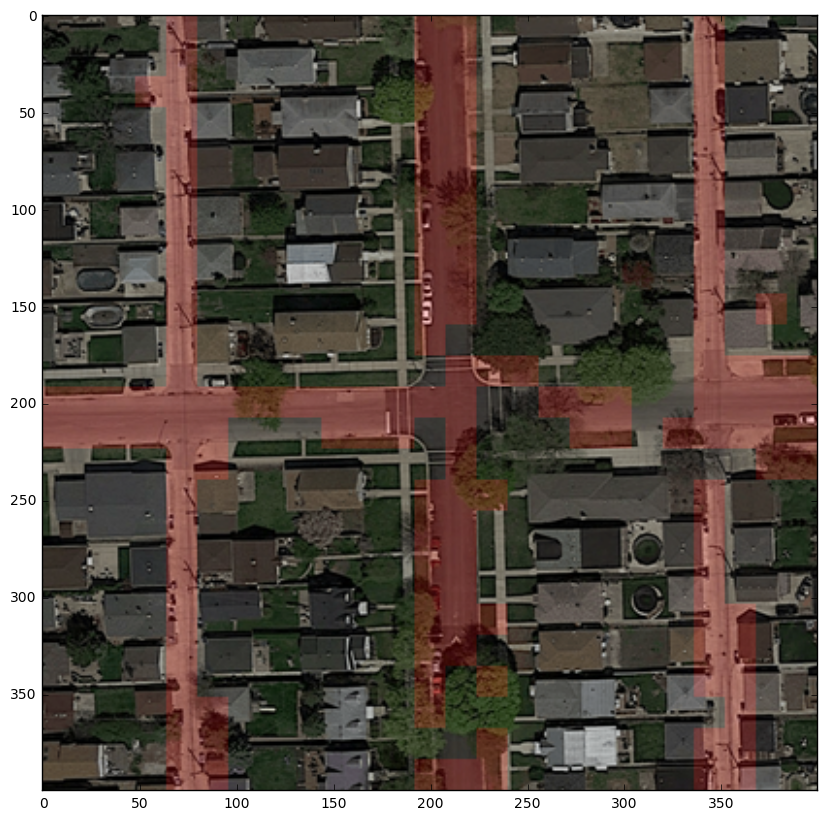

In [30]:
i = 1
display_ith_prediction(test, Z, i, window_width)

**problem**: it predicts always the same class [check here](https://stackoverflow.com/questions/41488279/neural-network-always-predicts-the-same-class)